In [ ]:
# Problématique : Sommes nous capable de pouvoir détecter les fraudes bien que fortement minoritaires dans ce dataframes ? 

In [45]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [46]:
Data = pd.read_csv("/mnt/c/Users/donov/Bureau/Fraude/Data/Data_processed.csv")

In [47]:
print(Data.head())

print(Data.info())

print(Data.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V23       V24       V25       V26       V27  \
0  0.098698  0.363787  ... -0.110474  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425  ...  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  ...  0.909412 -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024  ... -0.190321 -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  ... -0.137458  0.141267 -0.206010  0.502292  0.219422   

        V28  Amount  Class  heur

In [48]:
print(Data.isnull().sum())

print(f"Doublons : {Data.duplicated().sum()}")

Time             0
V1               0
V2               0
V3               0
V4               0
V5               0
V6               0
V7               0
V8               0
V9               0
V10              0
V11              0
V12              0
V13              0
V14              0
V15              0
V16              0
V17              0
V18              0
V19              0
V20              0
V21              0
V22              0
V23              0
V24              0
V25              0
V26              0
V27              0
V28              0
Amount           0
Class            0
heure_journée    0
jours            0
dtype: int64
Doublons : 0


In [49]:
# Preparation des X et y

# La target de cette étape sera bien évidemment class

feature_cols = [c for c in Data.columns if c != "Class"] 

X = Data[feature_cols].copy()

y = Data['Class'].astype(int)

# Création des sets train et test : 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y) #On garde la meme proportion de fraude que ce soit chez train ou test



In [50]:
#Scaling des colonnes Amount à jours car les autres ont deja subis un scaling via PCA

scale_cols = [c for c in ["Amount", "Time", "heure_journée","jours"] if c in X.columns]
preprocess = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), scale_cols)
    ],
    remainder="passthrough"  # pour laisser les colonnes v1 a v28 tranquille
)

In [51]:
# Régression logistique

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

pipe.fit(X_train, y_train)
#lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state = 42)
#lr.fit(X_train, y_train) # Etape de fitting

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1] #proba de fraude

# Affichage des résultats 

print("Classification :\n", classification_report(y_test, y_pred))
print("Matrice de confusion:\n", confusion_matrix(y_test, y_pred))
print("\nMatrice de confusion normalisée:\n", confusion_matrix(y_test, y_pred))
print("ROC_AUC_SCORE:", roc_auc_score(y_test, y_proba))

# Precision : Parmis toutes les transactions prédites comme fraude, combien le sont vraiment? (detecter les faux positifs %)
# recall : Parmis toutes les fraudes, combien le modèle a-t-il réussi a en détecter (%) ?
# F1 score : combiné du recall et de l'accuracy  

Classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.97      0.99     56746

Matrice de confusion:
 [[55238  1413]
 [   12    83]]

Matrice de confusion normalisée:
 [[55238  1413]
 [   12    83]]
ROC_AUC_SCORE: 0.9684722432548689


In [52]:
# 0 : 
# On detecte extremement bien les transactions normales, f1 score 99% excellent 

# 1 : 
# Concernant la class 1 (fraude) On a une tres mauvaise précision (6%), on a 94 fausses alertes de fraude sur 100 (accusation a tort) 
# Cependant on a un recall de 87% ce qui est tres bon, le modèle detecte quand meme 87% de vraies fraudes
# le F1 score est tres faible (10%) du fait que la précision soit extremement mauvaise (6%)

# ROC AUC
# on a un score ROC AUC de ~97%, il y a globalement une bonne discrimination des fraudes et transactions normales


# Conclusion

# Modèle extremement sensible mais possèdant un f1 score tres faible traduisant 
# d'un modèle qui génère beaucoup trop de faux positifs due a une très mauvaise précision des fraudes 

Classification:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.69      0.81        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.90     56746
weighted avg       1.00      1.00      1.00     56746

Matrice de confusion:
 [[56649     2]
 [   29    66]]
ROC_AUC_SCORE: 0.9446002253873905


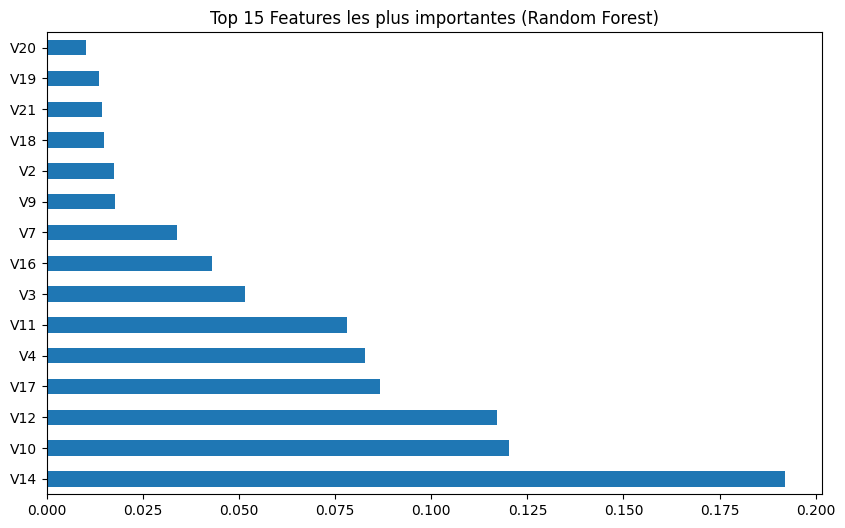

In [53]:
# Random forest 

rf = RandomForestClassifier(
    n_estimators=200,        # nb arbres
    max_depth=None,          # profondeur sans limite
    class_weight="balanced", # pour compenser la classe minoritaire
    random_state=42,
    n_jobs=-1                # parallélisation
)

rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

# Résultats
print("Classification:\n", classification_report(y_test, y_pred_rf))
print("Matrice de confusion:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC_AUC_SCORE:", roc_auc_score(y_test, y_proba_rf))

# Importance des variables

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances[:15].plot(kind="barh")
plt.title("Top 15 Features les plus importantes (Random Forest)")
plt.savefig("/mnt/c/Users/donov/Bureau/Fraude/Data/Outputs/Importances Features RF.png")
plt.show()

In [54]:
# 0 :

# On observe une precision, un recall et un f1 score excellent (100%), le modèle détecte parfaitement les transactions normales bien qu'il y ait tjrs 
# quelques faux positifs

# 1 : 

# Concernant les fraudes, comparé au modèle de régression logistique on a une nette amélioration de la précision (97%)
# et du f1 score (81%) mais un recall plus faible (69%)

# ROC AUC
# Le ROC AUC reste élevé (~94%), montrant une bonne capacité de discrimination globale,
# mais ce score masque les différences de performance entre les deux classes.


# Conclusion

# Modèle RandomForest très bon, détecte la majorité des fraudes et fait beaucoup moins de faux positifs que le modèle de régression logistique
# Cependant celui ci présente un recall plus faible et donc laisse échapper environ 30% des fraudes contre 17% pour le modèle de régression logistique

# La régression logistique privilégiait le rappel (détection de fraudes) au détriment de la précision, tandis que RandomForest équilibre 
# mieux les deux mais laisse échapper davantage de fraudes.


# Recommandation 

# RandomForest réduit fortement les faux positifs mais perd en couverture des fraudes. Pour une application en production, il serait 
# pertinent d’ajuster le seuil de décision ou de combiner avec des techniques de rééquilibrage afin d’améliorer le rappel.


In [55]:
# Amélioration du modèle 

rf_bal = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  
)

pipe_rf = Pipeline(steps=[("prep", preprocess), ("rf", rf_bal)])
pipe_rf.fit(X_train, y_train)

# Probabilités (class 1 = fraude)
proba_test = pipe_rf.predict_proba(X_test)[:, 1]

# AUC ROC (indépendant du seuil)
auc_roc = roc_auc_score(y_test, proba_test)
print(f"AUC ROC (seuil-indépendant) : {auc_roc:.4f}")

AUC ROC (seuil-indépendant) : 0.9432


In [56]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_at_threshold(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {
        "threshold": thr,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "tn": cm[0,0], "fp": cm[0,1], "fn": cm[1,0], "tp": cm[1,1]
    }

results = pd.DataFrame([evaluate_at_threshold(y_test, proba_test, thr) 
                        for thr in [0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20]])

# Affichage 

print("\nComparaison des seuils (class 1 = fraude) :")
print(results.to_string(index=False, 
                        formatters={
                            "precision_1": "{:.3f}".format,
                            "recall_1": "{:.3f}".format,
                            "f1_1": "{:.3f}".format,
                            "threshold": "{:.2f}".format
                        }))


Comparaison des seuils (class 1 = fraude) :
threshold precision_1 recall_1  f1_1    tn  fp  fn  tp
     0.50       0.985    0.705 0.822 56650   1  28  67
     0.45       0.958    0.716 0.819 56648   3  27  68
     0.40       0.958    0.726 0.826 56648   3  26  69
     0.35       0.958    0.726 0.826 56648   3  26  69
     0.30       0.959    0.737 0.833 56648   3  25  70
     0.25       0.947    0.747 0.835 56647   4  24  71
     0.20       0.924    0.768 0.839 56645   6  22  73


In [57]:
# Plus le seuil diminue, plus on augmente le recall (couverture des fraudes) , mais au prix de plus de faux positifs 
# Ici Le meilleur compromis est un treshold à 0.25 0.20

In [58]:
# Comparaison du modèle avec un modèle XGBoost

# Calcul de scale_pos_weight = (négatifs) / (positifs)

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = neg / max(1, pos)
print(f"scale_pos_weight = {spw:.1f}  (neg={neg}, pos={pos})")

scale_pos_weight = 599.5  (neg=226602, pos=378)


In [59]:
# Initialisation du modèle XGBoost

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=spw,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist"  
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", xgb)
])

# 6) Entraînement
pipe.fit(X_train, y_train)

# 7) Évaluation seuil 0.5
proba_test = pipe.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

print("\n=== XGBoost (seuil 0.5) ===")
print("ROC AUC :", roc_auc_score(y_test, proba_test))
print("Matrice de confusion:\n", confusion_matrix(y_test, pred_test))
print("Classification:\n", classification_report(y_test, pred_test, digits=4))


=== XGBoost (seuil 0.5) ===
ROC AUC : 0.9785605122406907
Matrice de confusion:
 [[56629    22]
 [   18    77]]
Classification:
               precision    recall  f1-score   support

           0     0.9997    0.9996    0.9996     56651
           1     0.7778    0.8105    0.7938        95

    accuracy                         0.9993     56746
   macro avg     0.8887    0.9051    0.8967     56746
weighted avg     0.9993    0.9993    0.9993     56746



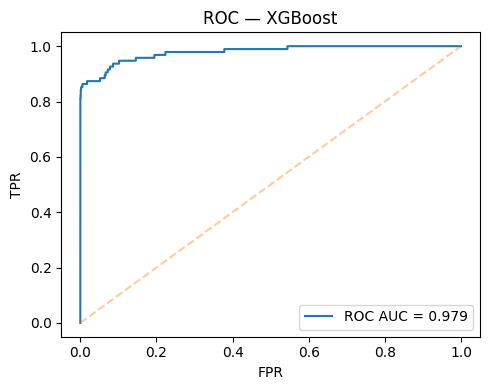

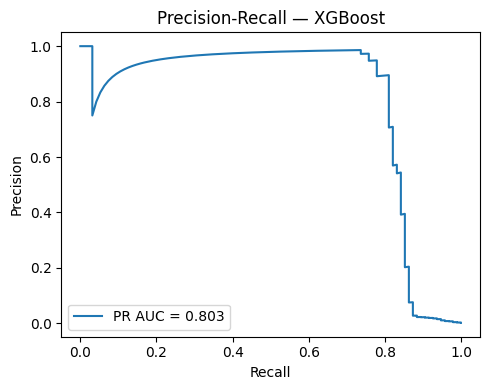

In [60]:
# Courbe ROC AUC et precision-recall

fpr, tpr, _ = roc_curve(y_test, proba_test)
prec, rec, thr = precision_recall_curve(y_test, proba_test)
pr_auc = auc(rec, prec)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, proba_test):.3f}")
plt.plot([0,1],[0,1],'--',alpha=0.4)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — XGBoost"); plt.legend(); plt.tight_layout()
plt.savefig("/mnt/c/Users/donov/Bureau/Fraude/Data/Outputs/ROC XGBoost.png")
plt.show()

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall — XGBoost"); plt.legend(); plt.tight_layout()
plt.savefig("/mnt/c/Users/donov/Bureau/Fraude/Data/Outputs/Precision-Recall XGBoost.png")
plt.show()

In [61]:
# Recherche du meilleur seuil 

best_f1, best_th = 0.0, 0.5
for t in np.linspace(0.05, 0.95, 19):
    p = (proba_test >= t).astype(int)
    # F1 de la classe 1
    from sklearn.metrics import f1_score
    f1_1 = f1_score(y_test, p, pos_label=1)
    if f1_1 > best_f1:
        best_f1, best_th = f1_1, t

print(f"\nSeuil optimisé (max F1 classe 1): {best_th:.2f} -> F1_1={best_f1:.3f}")
pred_best = (proba_test >= best_th).astype(int)
print("Matrice de confusion @best_th:\n", confusion_matrix(y_test, pred_best))
print("Classification @best_th:\n", classification_report(y_test, pred_best, digits=4))



Seuil optimisé (max F1 classe 1): 0.95 -> F1_1=0.852
Matrice de confusion @best_th:
 [[56649     2]
 [   23    72]]
Classification @best_th:
               precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     56651
           1     0.9730    0.7579    0.8521        95

    accuracy                         0.9996     56746
   macro avg     0.9863    0.8789    0.9259     56746
weighted avg     0.9995    0.9996    0.9995     56746



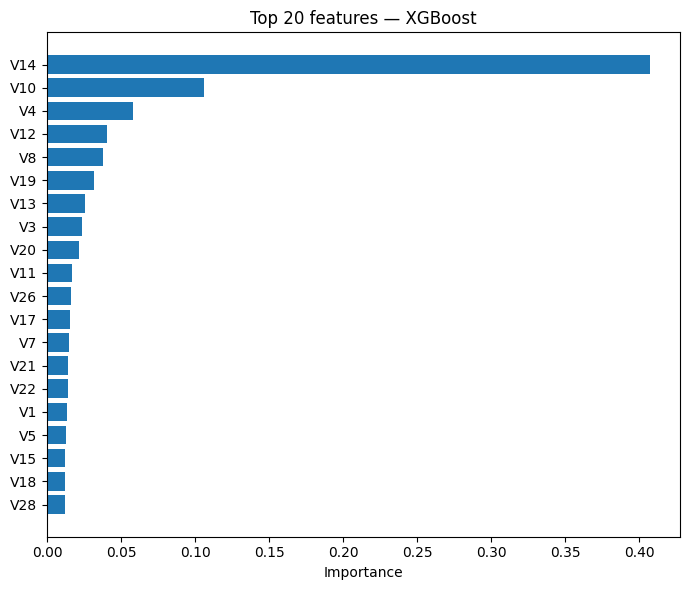

In [62]:
# Voir l'importance des différentes features

prep_fitted = pipe.named_steps["prep"]
xgb_fitted  = pipe.named_steps["xgb"]

final_feature_names = []
final_feature_names += scale_cols
final_feature_names += [c for c in X.columns if c not in scale_cols]

importances = xgb_fitted.feature_importances_
order = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(7,6))
plt.barh(np.array(final_feature_names)[order][::-1], importances[order][::-1])
plt.title("Top 20 features — XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("/mnt/c/Users/donov/Bureau/Fraude/Data/Outputs/Importances variables XGBoost.png")
plt.show()

In [63]:
# Couplage des modèles de prédiction à la méthode SMOTE 

# SMOTE va nous permettre de créer artificiellement de nouvelles données, donc ici des transaction frauduleuses pour équilibrer la class 0 et 1 
# Pour que le modèle apprenne a prédire aussi bien la class 0 (transaction normale) que la class 1 (fraude)

In [64]:
# 1) Régression logistique + SMOTE 

# Création d'une nouvelle pipeline

pipe_lr_smote = ImbPipeline(steps=[
    ("prep", preprocess),                         
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("lr", LogisticRegression(max_iter=1000, random_state=42))
])

# Entrainement du modèle 

pipe_lr_smote.fit(X_train, y_train)


,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [65]:
# 2) RandomForest + SMOTE 

# Création d'une nouvelle pipeline 

pipe_rf_smote = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("rf", RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1))
])

# Entrainement du modèle 

pipe_rf_smote.fit(X_train, y_train)

,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [66]:
# 3) Evaluation seuil-dépendance et tableau de comparaison 

def evaluate_thresholds(model, X_test, y_test, model_name="model", thresholds=None):
    if thresholds is None:
        thresholds = [0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20]

    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    prec, rec, thr = precision_recall_curve(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    pr_auc  = auc(rec, prec)

    rows = []
    for th in thresholds:
        y_pred = (proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        p, r, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average=None, labels=[0, 1], zero_division=0
        )
        rows.append({
            "model": model_name,
            "threshold": th,
            "precision_1": round(p[1], 3),
            "recall_1":    round(r[1], 3),
            "f1_1":        round(f1[1], 3),
            "tn": tn, "fp": fp, "fn": fn, "tp": tp
        })

    df = pd.DataFrame(rows)
    print(f"\nAUC ROC ({model_name}) : {roc_auc:.4f} | PR AUC : {pr_auc:.4f}")
    return df

# Tableaux de comparaison (classe 1 = fraude)

# Regression Logistique
tbl_lr_smote = evaluate_thresholds(pipe_lr_smote, X_test, y_test, model_name="LR+SMOTE")

# RanndomForest
tbl_rf_smote = evaluate_thresholds(pipe_rf_smote, X_test, y_test, model_name="RF+SMOTE")

# Résumé propre trié par f1 de la classe 1

#Regression Logistique
display(tbl_lr_smote.sort_values("f1_1", ascending=False).head(10))

#RandomForest
display(tbl_rf_smote.sort_values("f1_1", ascending=False).head(10))




AUC ROC (LR+SMOTE) : 0.9656 | PR AUC : 0.7173

AUC ROC (RF+SMOTE) : 0.9624 | PR AUC : 0.8146


,model,threshold,precision_1,recall_1,f1_1,tn,fp,fn,tp
0,LR+SMOTE,0.50,0.052,0.874,0.098,55141,1510,12,83
1,LR+SMOTE,0.45,0.044,0.874,0.085,54865,1786,12,83
2,LR+SMOTE,0.40,0.038,0.874,0.072,54525,2126,12,83
3,LR+SMOTE,0.35,0.031,0.874,0.061,54098,2553,12,83
4,LR+SMOTE,0.30,0.026,0.874,0.050,53495,3156,12,83
5,LR+SMOTE,0.25,0.021,0.905,0.042,52716,3935,9,86
6,LR+SMOTE,0.20,0.017,0.916,0.033,51636,5015,8,87


,model,threshold,precision_1,recall_1,f1_1,tn,fp,fn,tp
2,RF+SMOTE,0.40,0.880,0.768,0.820,56641,10,22,73
1,RF+SMOTE,0.45,0.899,0.747,0.816,56643,8,24,71
3,RF+SMOTE,0.35,0.843,0.789,0.815,56637,14,20,75
0,RF+SMOTE,0.50,0.909,0.737,0.814,56644,7,25,70
4,RF+SMOTE,0.30,0.809,0.800,0.804,56633,18,19,76
5,RF+SMOTE,0.25,0.794,0.811,0.802,56631,20,18,77
6,RF+SMOTE,0.20,0.675,0.811,0.737,56614,37,18,77


In [67]:
# LR + Smote : recall oscille aux alentour de 87-90% mais plus le seuil est bas plus la precision et le f1 score baisse 
# Détecte presque toutes les fraudes mais il y a beaucoup de faux positifs

# RF + smote : bon recall, précision et f1 score avec un seuil entre 0.35 et 0.40
# RF + SMOTE semble largement etre un meilleur candidat 

In [68]:
# Creation de la matrice de confusion 

best_th_lr = 0.50  
best_th_rf = 0.40

for name, mdl in [("LR+SMOTE", pipe_lr_smote)]:
    proba = mdl.predict_proba(X_test)[:, 1]
    y_pred = (proba >= best_th_lr).astype(int)
    print(f"\n=== {name} @ threshold={best_th_lr} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("Matrice de confusion:\n", confusion_matrix(y_test, y_pred))

for name, mdl in [("RF+SMOTE", pipe_rf_smote)]:
    proba = mdl.predict_proba(X_test)[:, 1]
    y_pred = (proba >= best_th_rf).astype(int)
    print(f"\n=== {name} @ threshold={best_th_rf} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("Matrice de confusion:\n", confusion_matrix(y_test, y_pred))


=== LR+SMOTE @ threshold=0.5 ===
              precision    recall  f1-score   support

           0      1.000     0.973     0.986     56651
           1      0.052     0.874     0.098        95

    accuracy                          0.973     56746
   macro avg      0.526     0.924     0.542     56746
weighted avg      0.998     0.973     0.985     56746

Matrice de confusion:
 [[55141  1510]
 [   12    83]]

=== RF+SMOTE @ threshold=0.4 ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     56651
           1      0.880     0.768     0.820        95

    accuracy                          0.999     56746
   macro avg      0.940     0.884     0.910     56746
weighted avg      0.999     0.999     0.999     56746

Matrice de confusion:
 [[56641    10]
 [   22    73]]


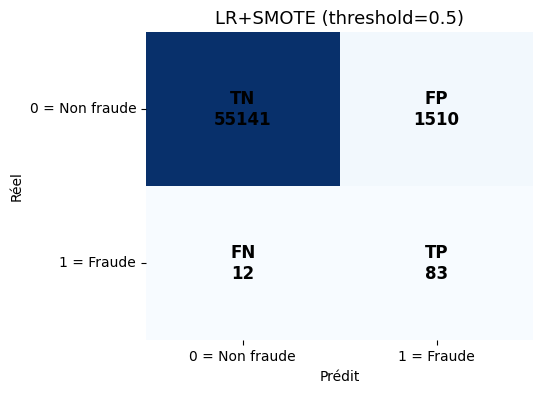

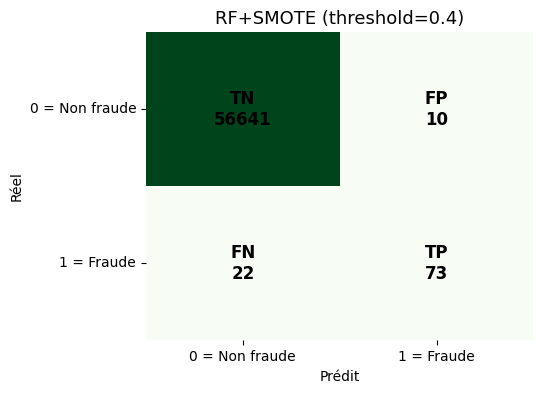

In [69]:
# Creation des heatmaps

# Plots 

def plot_confusion_matrix(y_test, y_pred, title, cmap="Blues"):
    cm = confusion_matrix(y_test, y_pred)
    labels = np.array([["TN", "FP"], ["FN", "TP"]])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=False, fmt="d", cmap=cmap, cbar=False)

    # Ajout du texte explicatif dans chaque case
    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.5,
                     f"{labels[i,j]}\n{cm[i,j]}",
                     ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.title(title, fontsize=13)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.xticks([0.5,1.5], ["0 = Non fraude", "1 = Fraude"])
    plt.yticks([0.5,1.5], ["0 = Non fraude", "1 = Fraude"], rotation=0)
    plt.savefig("/mnt/c/Users/donov/Bureau/Fraude/Data/Outputs/Heatmaps LR+SMOTE - RF+SMOTE.png")
    plt.show()

# Matrice de confusion 

plot_confusion_matrix(y_test, (pipe_lr_smote.predict_proba(X_test)[:,1]>=0.5).astype(int),
                      "LR+SMOTE (threshold=0.5)", cmap="Blues")

plot_confusion_matrix(y_test, (pipe_rf_smote.predict_proba(X_test)[:,1]>=0.4).astype(int),
                      "RF+SMOTE (threshold=0.4)", cmap="Greens")

In [70]:
# TN : True Negatives, Transactions normales bien classées
# FP : False Positives, Transactions normales mal classées
# FN : False Negatives, Fraudes non detectées
# TP : True Positives, Fraudes détectées 

In [71]:
# XGBoost + SMOTE 

# Creation de la pipeline XGBoost + SMOTE

pipe_xgb_smote = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42, sampling_strategy=0.2)),
    ("xgb", XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        # NB: avec SMOTE, on laisse généralement scale_pos_weight=1
    ))
])

# Entrainement du modèle 

pipe_xgb_smote.fit(X_train, y_train)

,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [72]:
# Resultats et matrice de confusion

proba_xgb = pipe_xgb_smote.predict_proba(X_test)[:, 1]
y_pred_05 = (proba_xgb >= 0.5).astype(int)

print("=== XGB + SMOTE @ threshold=0.5 ===")
print(classification_report(y_test, y_pred_05, digits=3))
print("Matrice de confusion:\n", confusion_matrix(y_test, y_pred_05))
print("ROC AUC:", roc_auc_score(y_test, proba_xgb))

=== XGB + SMOTE @ threshold=0.5 ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     56651
           1      0.798     0.789     0.794        95

    accuracy                          0.999     56746
   macro avg      0.899     0.895     0.897     56746
weighted avg      0.999     0.999     0.999     56746

Matrice de confusion:
 [[56632    19]
 [   20    75]]
ROC AUC: 0.9739303157188659


In [73]:
# Comparaison des seuils 

def eval_thresholds_y1(y_true, proba, thresholds=(0.50,0.45,0.40,0.35,0.30,0.25,0.20)):
    rows = []
    for th in thresholds:
        y_pred = (proba >= th).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec  = tp / (tp + fn) if (tp + fn) else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
        rows.append([th, prec, rec, f1, tn, fp, fn, tp])
    import pandas as pd
    return pd.DataFrame(rows, columns=["threshold","precision_1","recall_1","f1_1","tn","fp","fn","tp"])

tbl_xgb = eval_thresholds_y1(y_test, proba_xgb)
print("\nComparaison des seuils (classe 1 = fraude) :")
print(tbl_xgb.to_string(index=False))


Comparaison des seuils (classe 1 = fraude) :
 threshold  precision_1  recall_1     f1_1    tn  fp  fn  tp
      0.50     0.797872  0.789474 0.793651 56632  19  20  75
      0.45     0.781250  0.789474 0.785340 56630  21  20  75
      0.40     0.735294  0.789474 0.761421 56624  27  20  75
      0.35     0.700935  0.789474 0.742574 56619  32  20  75
      0.30     0.652174  0.789474 0.714286 56611  40  20  75
      0.25     0.603175  0.800000 0.687783 56601  50  19  76
      0.20     0.541667  0.821053 0.652720 56585  66  17  78


In [74]:
# Plus le seuil baisse plus on observe une hausse du recall mais une baisse de la précision
# Le modèle détecte plus de fraude mais il y a beaucoup plus de faux positif

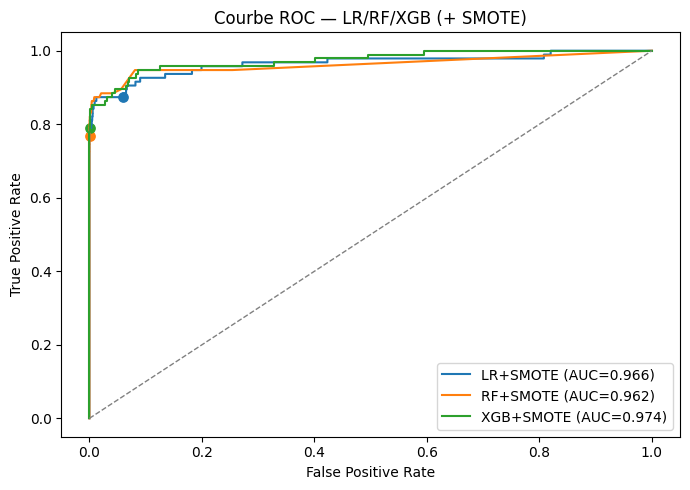

In [75]:
# Courbe ROC de nos différents modèles 

models = {
    "LR+SMOTE":  (pipe_lr_smote,  0.50),
    "RF+SMOTE":  (pipe_rf_smote,  0.40),
    "XGB+SMOTE": (pipe_xgb_smote, 0.50),  
} # Seuil choisi en fonction des meilleurs seuils trouvés lors de nots précédentes étapes 

# Courbe ROC 

plt.figure(figsize=(7,5))
for name, (mdl, th) in models.items():
    proba = mdl.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, proba)
    auc_roc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_roc:.3f})")

    # Marqueur au seuil choisi
    # On prend le point dont le seuil est le plus proche de 'th'
    idx = np.argmin(np.abs(thr - th)) if len(thr) > 0 else None
    if idx is not None and idx < len(fpr):
        plt.scatter(fpr[idx], tpr[idx], s=45, marker="o")

plt.plot([0,1],[0,1], linestyle="--", linewidth=1, color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC — LR/RF/XGB (+ SMOTE)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("/mnt/c/Users/donov/Bureau/Fraude/Data/Outputs/ROC LR-RF-XGB(+SMOTE).png")
plt.show()

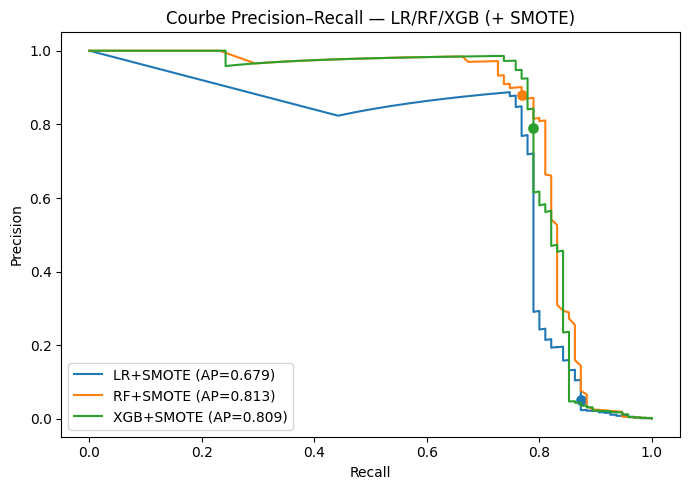

In [76]:
# Précision-recall de nos différents modèles 

plt.figure(figsize=(7,5))
for name, (mdl, th) in models.items():
    proba = mdl.predict_proba(X_test)[:, 1]
    precision, recall, thr = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

    # Marqueur au seuil choisi (approx)
    # precision_recall_curve renvoie thr de taille (n-1). On interpole grossièrement.
    if len(thr) > 0:
        idx = np.argmin(np.abs(thr - th))
        # idx correspond au point entre (recall[idx], precision[idx])
        plt.scatter(recall[idx], precision[idx], s=45, marker="o")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision–Recall — LR/RF/XGB (+ SMOTE)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("/mnt/c/Users/donov/Bureau/Fraude/Data/Outputs/ Courbe Precision-Recall LR-RF-XGB(+SMOTE).png")
plt.show()